In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Covariance

In [2]:
def exponential_cov(x, y, params):
    # kernel
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)

def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return (mu.squeeze(), sigma.squeeze())

cov of 0 and 0: 1.0


<ErrorbarContainer object of 3 artists>

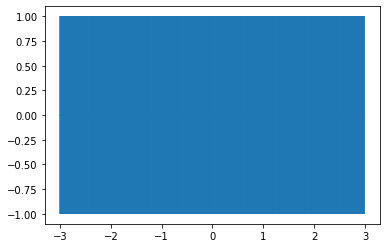

In [3]:
theta = [1, 10]  # params
theta_0 = exponential_cov(0, 0, theta)
print("cov of 0 and 0:", theta_0)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=theta_0, capsize=0)

In [5]:
x = [1.]
y = [np.random.normal(scale=theta_0)]
y

[-0.9523416546614363]

In [6]:
theta_1 = exponential_cov(x, x, theta)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, theta_1, y) for i in x_pred]

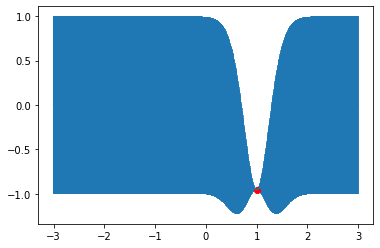

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [48]:
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
y2

-1.057547972950803

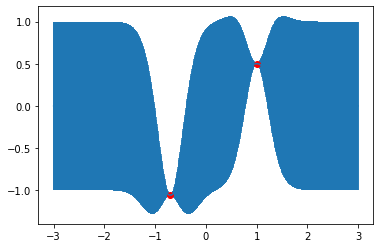

In [49]:
x.append(-0.7)
y.append(y2)
 
theta_2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, theta_2, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [40]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-0.89530762, -1.07348478,  1.28060113, -0.42567031, -1.30061975])

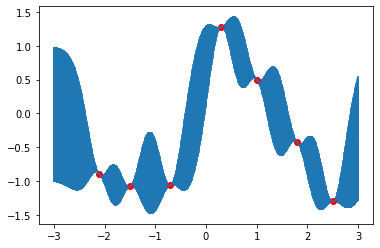

In [50]:
x += x_more
y += y_more.tolist()
 
theta_new = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, theta_new, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

/Users/jeremy.zhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


(-10.577494824415874,
 10.207749851457285,
 -46.45728555959633,
 39.04140469387481)

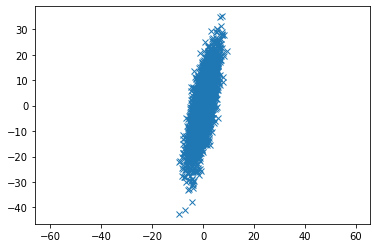

In [70]:
mean = [0, 0]
cov = [[1, 20], [20, 100]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 5000).T

plt.plot(x, y, 'x')
plt.axis('equal')

In [71]:
from scipy.stats import multivariate_normal

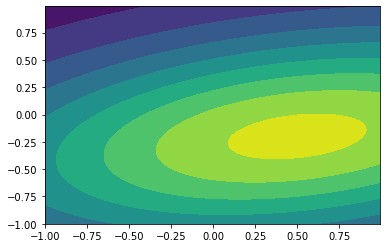

In [73]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

plt.contourf(x, y, rv.pdf(pos))

In [79]:
rv.pdf([0.6, -0.2])

0.16638199169788842